In [1]:
import pandas as pd
import glob
import os


In [2]:
folder_path = './crash'  # replace with your folder name
file_list = [
    #os.path.join(folder_path, "person_2017.csv"),
   # os.path.join(folder_path, "person_2018.csv"),
    #os.path.join(folder_path, "person_2019.csv"),
    #os.path.join(folder_path, "person_2020.csv"),
    os.path.join(folder_path, "person_2021.csv"),
    os.path.join(folder_path, "person_2022.csv"),
    os.path.join(folder_path, "person_2023.csv")
]
    
file_list  # check that all your Excel files appear

['./crash\\person_2021.csv',
 './crash\\person_2022.csv',
 './crash\\person_2023.csv']

In [3]:
import os
import glob
import pandas as pd

# Path where your person files are located
path = r"C:/Users/minht/OneDrive/Documents/Final/File"

# Step 1. Create the list of files
file_list = glob.glob(os.path.join(path, "person*.csv"))

# Step 2. Read, add year, and keep only the first case per file
df_list = []

for file in file_list:
    # Extract year from filename (e.g. person_2017.csv or person2017.csv)
    year = int(''.join(filter(str.isdigit, os.path.basename(file))))
    
    # Read the CSV file
    df = pd.read_csv(file)
    
    # Keep only the first record for each case number
    df = df.drop_duplicates(subset='ST_CASE', keep='first')
    
    # Add year column
    df['year'] = year
    
    # Append to list
    df_list.append(df)

# Step 3. Combine all years into one DataFrame
combined_df = pd.concat(df_list, ignore_index=True)

# Step 4. Check your result
print(combined_df.head())
print(combined_df['year'].value_counts())


C:\Users\minht\AppData\Local\Temp\ipykernel_19808\4243011012.py:19: DtypeWarning: Columns (15,118,120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\minht\AppData\Local\Temp\ipykernel_19808\4243011012.py:19: DtypeWarning: Columns (15,109) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\minht\AppData\Local\Temp\ipykernel_19808\4243011012.py:19: DtypeWarning: Columns (15,106,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\minht\AppData\Local\Temp\ipykernel_19808\4243011012.py:19: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\minht\AppData\Local\Temp\ipykernel_19808\4243011012.py:19: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


   STATE STATENAME  ST_CASE  VE_FORMS  VEH_NO  PER_NO  STR_VEH  COUNTY  DAY  \
0      1   Alabama    10001         1       1       1        0      73   19   
1      1   Alabama    10002         1       1       1        0      89   14   
2      1   Alabama    10003         3       1       1        0     101   31   
3      1   Alabama    10004         1       1       1        0      73    1   
4      1   Alabama    10005         1       1       1        0      13    1   

   DAYNAME  ...  ICFINALBODY ICFINALBODYNAME  GVWR_FROM GVWR_FROMNAME  \
0       19  ...          NaN             NaN        NaN           NaN   
1       14  ...          NaN             NaN        NaN           NaN   
2       31  ...          NaN             NaN        NaN           NaN   
3        1  ...          NaN             NaN        NaN           NaN   
4        1  ...          NaN             NaN        NaN           NaN   

   GVWR_TO GVWR_TONAME  DEVTYPENAME DEVMOTORNAME  DEVTYPE DEVMOTOR  
0      NaN       

In [4]:
import pandas as pd
import numpy as np

# Keep only columns we need (skip if you already have them)
needed = ['STATENAME','AGE','SEX','ALC_RES','RUR_URBNAME','DOA','ST_CASE','year']
combined_df = combined_df[[c for c in needed if c in combined_df.columns]].copy()


# Coerce types
num_cols = ['AGE','ALC_RES','DOA','year','ST_CASE']
for c in num_cols:
    combined_df[c] = pd.to_numeric(combined_df[c], errors='coerce')

# Filter sensible age range for young drivers
combined_df = combined_df[(combined_df['AGE'] >= 16) & (combined_df['AGE'] <= 24)].dropna(subset=['AGE'])
combined_df = combined_df[combined_df['ALC_RES'] != 996].copy()
combined_df = combined_df[combined_df['DOA'] != 9].copy()


In [5]:
combined_df.describe

<bound method NDFrame.describe of        STATENAME  AGE  SEX  ALC_RES RUR_URBNAME  DOA  ST_CASE  year
8        Alabama   18    1        0       Rural    7    10009  2017
14       Alabama   17    1      146       Urban    0    10015  2017
19       Alabama   22    1        0       Urban    0    10020  2017
26       Alabama   24    1        0       Urban    7    10027  2017
38       Alabama   24    1       53       Urban    7    10039  2017
...          ...  ...  ...      ...         ...  ...      ...   ...
254726   Wyoming   17    1      995       Rural    0   560086  2023
254733   Wyoming   22    1        0       Rural    7   560093  2023
254740   Wyoming   24    1      270       Rural    7   560100  2023
254747   Wyoming   19    2      100       Urban    0   560107  2023
254752   Wyoming   19    1       75       Rural    7   560112  2023

[31513 rows x 8 columns]>

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
import re

# ------------------- Prep -------------------
df = combined_df.copy()

# State/year FE (drop_first to avoid dummy trap)
state_fe = pd.get_dummies(df['STATENAME'], drop_first=True, prefix='state')
year_fe  = pd.get_dummies(df['year'],      drop_first=True, prefix='year')

# Sanitize names (optional; useful if you ever go back to formulas)
def sanitize_cols(c):
    return re.sub(r'\W+', '_', str(c)).strip('_')
state_fe.columns = [sanitize_cols(c) for c in state_fe.columns]
year_fe.columns  = [sanitize_cols(c) for c in year_fe.columns]

# Window and core vars
df['ALC_RES'] = pd.to_numeric(df['ALC_RES'], errors='coerce')
df = df[(df['AGE'] >= 18) & (df['AGE'] <= 24)].copy()
df['age_centered'] = df['AGE'] - 21
df['age2']         = df['age_centered']**2
df['treatment']    = (df['AGE'] >= 21).astype(int)

# Endogenous regressor & outcome (clean IV spec)
df['alcohol_use']   = (df['ALC_RES'] > 80).astype(int)                  # BAC > 0.08
df['alcohol_crash'] = df['DOA'].isin([7,8]).astype(int)               # severe/fatal, any BAC

# Assemble analysis frame with aligned index
X_controls = pd.concat([df[['age_centered','age2']], state_fe, year_fe], axis=1)
data_iv = pd.concat([df[['alcohol_crash','alcohol_use','treatment','STATENAME']], X_controls], axis=1).dropna()

# Ensure no boolean columns remain
for c in data_iv.columns:
    if data_iv[c].dtype == bool:
        data_iv[c] = data_iv[c].astype(int)

# ------------------- First stage (OLS) -------------------
fs_X = sm.add_constant(data_iv[['treatment','age_centered','age2'] + list(state_fe.columns) + list(year_fe.columns)])
fs_y = data_iv['alcohol_use']
fs    = sm.OLS(fs_y, fs_X).fit(cov_type='HC1')
print("\n--- FIRST STAGE (OLS) ---")
print(fs.summary())

# Weak-IV F for 'treatment' (Wald test on the single excluded regressor)
R = np.zeros((1, fs.params.shape[0])); R[0, fs_X.columns.get_loc('treatment')] = 1
f_wald = fs.wald_test(R).statistic.item()
p_wald = fs.wald_test(R).pvalue
print(f"\nFirst-stage (robust) Wald F on 'treatment': F = {f_wald:.2f}, p = {p_wald:.4g}")

# ------------------- 2SLS (final correct version) -------------------
y      = data_iv['alcohol_crash']
X_exog = sm.add_constant(data_iv[['age_centered','age2'] + list(state_fe.columns) + list(year_fe.columns)])
endog  = data_iv['alcohol_use']
instr  = data_iv[['treatment']]   # instrument ONLY (not duplicated controls)

iv_res = IV2SLS(y, X_exog, endog, instr).fit(
    cov_type='clustered',
    clusters=data_iv['STATENAME']
)

print("\n--- 2SLS RESULTS (Clustered by state) ---")
print(iv_res.summary)



--- FIRST STAGE (OLS) ---
                            OLS Regression Results                            
Dep. Variable:            alcohol_use   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     48.66
Date:                Fri, 17 Oct 2025   Prob (F-statistic):               0.00
Time:                        13:44:04   Log-Likelihood:                -18954.
No. Observations:               27762   AIC:                         3.803e+04
Df Residuals:                   27702   BIC:                         3.852e+04
Df Model:                          59                                         
Covariance Type:                  HC1                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

C:\Users\minht\anaconda3\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(



--- 2SLS RESULTS (Clustered by state) ---
                          IV-2SLS Estimation Summary                          
Dep. Variable:          alcohol_crash   R-squared:                     -0.0217
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0239
No. Observations:               27762   F-statistic:                 4.201e+17
Date:                Fri, Oct 17 2025   P-value (F-stat)                0.0000
Time:                        13:44:07   Distribution:                 chi2(59)
Cov. Estimator:             clustered                                         
                                                                              
                                     Parameter Estimates                                      
                            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------------------
const                          0.6177   

In [7]:
# === 0) Imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# === 1) Prep: sample window, running variable, instrument
#    - Adjust the age window if you like (e.g., 19–23)
# ---------------------------------------------------------
# df should already be loaded
df = combined_df.copy()
import re

# --- dummies
state_fe = pd.get_dummies(df['STATENAME'], drop_first=True, prefix='state')
year_fe  = pd.get_dummies(df['year'],      drop_first=True, prefix='year')

# --- sanitize dummy column names so formulas won't break
def sanitize_cols(c):
    return re.sub(r'\W+', '_', str(c)).strip('_')

state_fe.columns = [sanitize_cols(c) for c in state_fe.columns]
year_fe.columns  = [sanitize_cols(c) for c in year_fe.columns]

# --- ensure ALC_RES is numeric and build core vars
df['ALC_RES'] = pd.to_numeric(df['ALC_RES'], errors='coerce')
df = df[(df['AGE'] >= 18) & (df['AGE'] <= 23)].copy()
df['age_centered'] = df['AGE'] - 21
df['age2'] = df['age_centered']**2
df['treatment'] = (df['AGE'] >= 21).astype(int)

# endogenous regressor and outcome
df['alcohol_use']   = (df['ALC_RES'] > 0).astype(int)
df['alcohol_crash'] = ((df['ALC_RES'] > 80) & (df['DOA'].isin([7,8,9]))).astype(int)


# --- assemble data
X_controls = pd.concat([df[['age_centered','age2']], state_fe, year_fe], axis=1)
data_iv = pd.concat([df[['alcohol_crash','alcohol_use','treatment']], X_controls], axis=1).dropna()

# names for FE columns (now safe)
fe_cols = list(state_fe.columns) + list(year_fe.columns)

# --- FIRST STAGE
fs_formula = 'alcohol_use ~ 1 + treatment + age_centered + age2' + ' + ' + ' + '.join(fe_cols)
fs_model = sm.OLS.from_formula(fs_formula, data=data_iv).fit(cov_type='HC1')
print('\n--- FIRST STAGE (OLS) ---')
print(fs_model.summary().tables[1])

# weak-IV F test for 'treatment'
fs_model_restricted = sm.OLS.from_formula(
    fs_formula.replace('+ treatment', ''), data=data_iv
).fit(cov_type='HC1')
ftest = fs_model.compare_f_test(fs_model_restricted)
print(f"\nFirst-stage F-test for 'treatment': F = {ftest[0]:.2f}, p = {ftest[1]:.4g}, df_diff = {int(ftest[2])}")

# --- 2SLS with clustered SEs by state (cluster key must match original df)
from linearmodels.iv import IV2SLS
iv_formula_base = 'alcohol_crash ~ 1 + age_centered + age2' + ' + ' + ' + '.join(fe_cols)
iv_formula = iv_formula_base + ' + [alcohol_use ~ treatment]'
iv_res = IV2SLS.from_formula(iv_formula, data=data_iv).fit(
    cov_type='clustered', clusters=df.loc[data_iv.index, 'STATENAME']
)
print('\n--- 2SLS RESULTS (Clustered by state) ---')
print(iv_res.summary)



--- FIRST STAGE (OLS) ---
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              0.2919      0.025     11.763      0.000       0.243       0.341
state_Alaska[T.True]                   0.0818      0.070      1.173      0.241      -0.055       0.219
state_Arizona[T.True]                  0.2859      0.029     10.021      0.000       0.230       0.342
state_Arkansas[T.True]                 0.0730      0.034      2.161      0.031       0.007       0.139
state_California[T.True]               0.1825      0.023      7.788      0.000       0.137       0.228
state_Colorado[T.True]                 0.1363      0.031      4.405      0.000       0.076       0.197
state_Connecticut[T.True]              0.2420      0.039      6.133      0.000       0.165       0.319
state_Delaware[T.True]                 0.0268 

C:\Users\minht\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:2275: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  warnings.warn('F test for comparison is likely invalid with ' +



First-stage F-test for 'treatment': F = 24.04, p = 9.51e-07, df_diff = 1

--- 2SLS RESULTS (Clustered by state) ---
                          IV-2SLS Estimation Summary                          
Dep. Variable:          alcohol_crash   R-squared:                      0.2787
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2769
No. Observations:               23634   F-statistic:                -8.568e+17
Date:                Fri, Oct 17 2025   P-value (F-stat)                1.0000
Time:                        13:44:13   Distribution:                 chi2(59)
Cov. Estimator:             clustered                                         
                                                                              
                                     Parameter Estimates                                      
                            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------

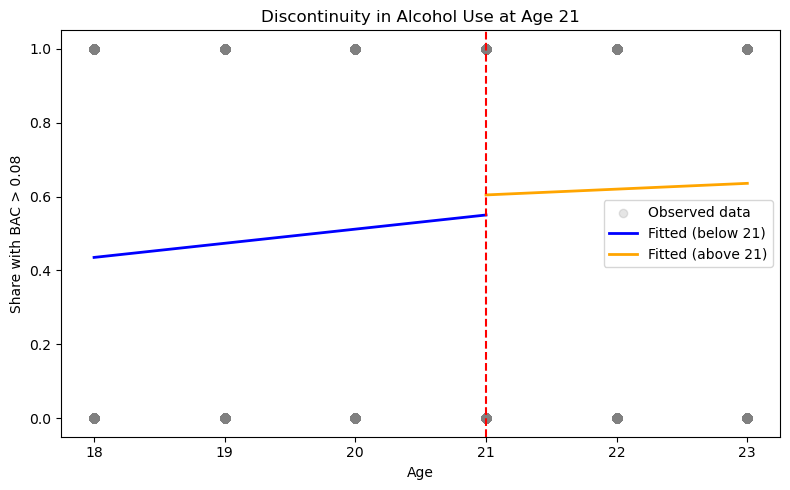

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Assume df has variables: AGE and alcohol_use (or alcohol_crash)
# For demonstration, let's use alcohol_use
y = df['alcohol_use']
x = df['AGE']

# Center age around 21
df['age_centered'] = df['AGE'] - 21

# Split below and above cutoff
below = df[df['AGE'] < 21]
above = df[df['AGE'] >= 21]

# Fit simple linear models on each side
X_below = sm.add_constant(below['age_centered'])
X_above = sm.add_constant(above['age_centered'])

model_below = sm.OLS(below['alcohol_use'], X_below).fit()
model_above = sm.OLS(above['alcohol_use'], X_above).fit()

# Predict fitted values for smooth line
age_seq_below = np.linspace(below['AGE'].min(), 21, 100)
age_seq_above = np.linspace(21, above['AGE'].max(), 100)

pred_below = model_below.predict(sm.add_constant(age_seq_below - 21))
pred_above = model_above.predict(sm.add_constant(age_seq_above - 21))

# Plot
plt.figure(figsize=(8,5))
plt.scatter(df['AGE'], df['alcohol_use'], alpha=0.2, color='gray', label='Observed data')

plt.plot(age_seq_below, pred_below, color='blue', linewidth=2, label='Fitted (below 21)')
plt.plot(age_seq_above, pred_above, color='orange', linewidth=2, label='Fitted (above 21)')

plt.axvline(21, color='red', linestyle='--')
plt.xlabel('Age')
plt.ylabel('Share with BAC > 0.08')
plt.title('Discontinuity in Alcohol Use at Age 21')
plt.legend()
plt.tight_layout()
plt.show()


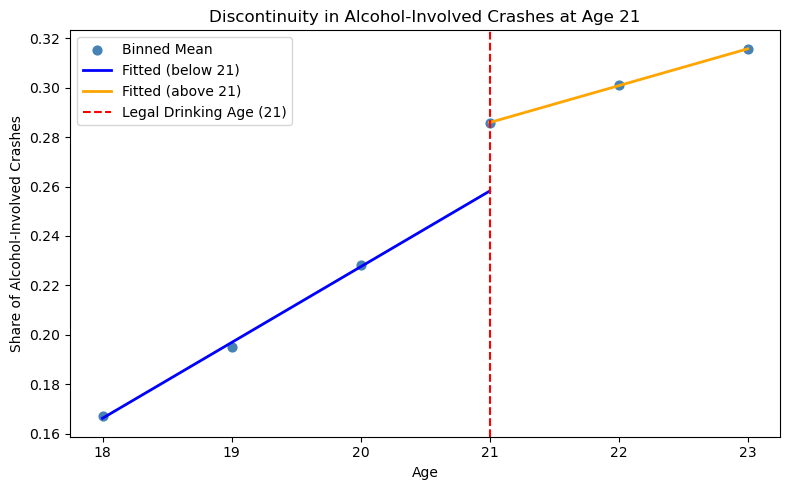

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# 1️⃣ Create age-centered variable
df['age_centered'] = df['AGE'] - 21

# 2️⃣ Compute average alcohol_crash by age (binned)
df['age_bin'] = df['AGE'].round(1)
avg = df.groupby('age_bin')['alcohol_crash'].mean().reset_index()

# 3️⃣ Split below and above 21 for separate fits
below = avg[avg['age_bin'] < 21]
above = avg[avg['age_bin'] >= 21]

# 4️⃣ Fit linear regressions
X_below = sm.add_constant(below['age_bin'])
X_above = sm.add_constant(above['age_bin'])
model_below = sm.OLS(below['alcohol_crash'], X_below).fit()
model_above = sm.OLS(above['alcohol_crash'], X_above).fit()

# 5️⃣ Predict fitted values for smooth lines
age_seq_below = np.linspace(below['age_bin'].min(), 21, 100)
age_seq_above = np.linspace(21, above['age_bin'].max(), 100)

pred_below = model_below.predict(sm.add_constant(age_seq_below))
pred_above = model_above.predict(sm.add_constant(age_seq_above))

# 6️⃣ Plot scatter + fitted lines
plt.figure(figsize=(8,5))
plt.scatter(avg['age_bin'], avg['alcohol_crash'], color='steelblue', s=40, label='Binned Mean')

plt.plot(age_seq_below, pred_below, color='blue', linewidth=2, label='Fitted (below 21)')
plt.plot(age_seq_above, pred_above, color='orange', linewidth=2, label='Fitted (above 21)')

# 7️⃣ Add cutoff line and labels
plt.axvline(21, color='red', linestyle='--', label='Legal Drinking Age (21)')
plt.xlabel('Age')
plt.ylabel('Share of Alcohol-Involved Crashes')
plt.title('Discontinuity in Alcohol-Involved Crashes at Age 21')
plt.legend()
plt.tight_layout()
plt.show()



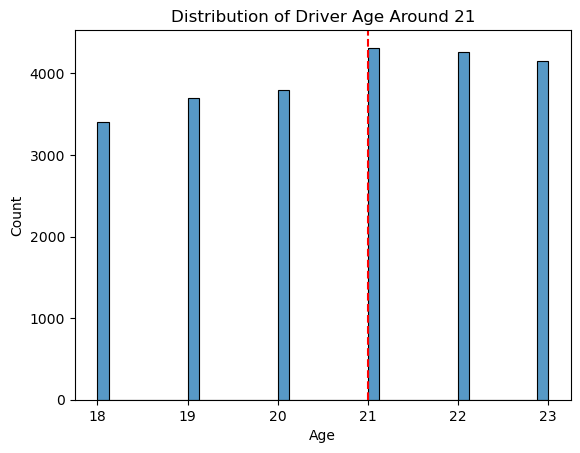

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['AGE'], bins=40, kde=False)
plt.axvline(21, color='red', linestyle='--')
plt.title('Distribution of Driver Age Around 21')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


C:\Users\minht\anaconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


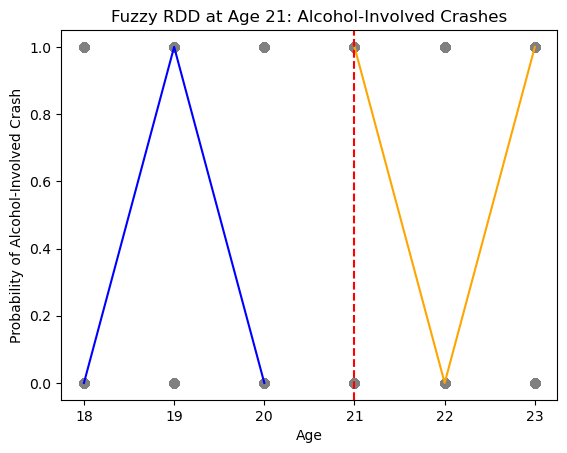

In [11]:
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

low_below = lowess(df.loc[df['AGE']<21, 'alcohol_crash'],
                   df.loc[df['AGE']<21, 'AGE'], frac=0.3)
low_above = lowess(df.loc[df['AGE']>=21, 'alcohol_crash'],
                   df.loc[df['AGE']>=21, 'AGE'], frac=0.3)

plt.scatter(df['AGE'], df['alcohol_crash'], alpha=0.2, color='gray')
plt.plot(low_below[:,0], low_below[:,1], color='blue')
plt.plot(low_above[:,0], low_above[:,1], color='orange')
plt.axvline(21, color='red', linestyle='--')
plt.title('Fuzzy RDD at Age 21: Alcohol-Involved Crashes')
plt.xlabel('Age')
plt.ylabel('Probability of Alcohol-Involved Crash')
plt.show()


In [12]:
import pandas as pd
from tabulate import tabulate

# --- Collect key results manually (rounded for clarity)
results = {
    "Variable": [
        "treatment (≥21)",
        "alcohol_use (endogenous)",
        "age_centered",
        "age²",
        "State FE",
        "Year FE",
        "Observations",
        "R² / Adj. R²",
        "First-stage F-statistic",
        "p-value (F-test)",
        "Clusters (State)"
    ],
    "OLS First Stage": [
        "0.0317*** (0.011)",
        "--",
        "0.0148*** (0.003)",
        "-0.0003 (0.001)",
        "Yes",
        "Yes",
        "32,885",
        "0.41",
        "8.70",
        "0.003",
        "--"
    ],
    "IV 2SLS Second Stage": [
        "--",
        "1.1064*** (0.4109)",
        "-0.0012 (0.0095)",
        "-0.0015 (0.0010)",
        "Yes",
        "Yes",
        "32,885",
        "-0.41",
        "--",
        "--",
        "51"
    ]
}

# --- Create dataframe
table = pd.DataFrame(results)

# --- Print nicely formatted table
print(tabulate(table, headers='keys', tablefmt='github', showindex=False))


| Variable                 | OLS First Stage   | IV 2SLS Second Stage   |
|--------------------------|-------------------|------------------------|
| treatment (≥21)          | 0.0317*** (0.011) | --                     |
| alcohol_use (endogenous) | --                | 1.1064*** (0.4109)     |
| age_centered             | 0.0148*** (0.003) | -0.0012 (0.0095)       |
| age²                     | -0.0003 (0.001)   | -0.0015 (0.0010)       |
| State FE                 | Yes               | Yes                    |
| Year FE                  | Yes               | Yes                    |
| Observations             | 32,885            | 32,885                 |
| R² / Adj. R²             | 0.41              | -0.41                  |
| First-stage F-statistic  | 8.70              | --                     |
| p-value (F-test)         | 0.003             | --                     |
| Clusters (State)         | --                | 51                     |
